# Model 19: The evolution of social learning strategies

original: https://bookdown.org/amesoudi/ABMtutorial_bookdown/model19.html

## Introduction

- Model 18b showed that social learning can readily evolve when combined with individual learning.
    - いわゆる critical learners、まず人の真似 (社会的学習) をして、その行動が誤っていれば個人的学習を試みる学習者は、純粋な社会的学習者や個人的学習者よりも良い結果を残す。
    - しかし、Model 18 の社会的学習者は、バイアスなしの伝播を採用していた。つまり、ランダムなエージェントを選択してその行動をコピーしていた。これは現実的ではない。
- Model 19 では、もう少し洗練された社会的学習 (ペイオフバイアス伝播 (Model 3) や多数派バイアス伝播 (Model 5)) について調べていこう。
    - Model 3 や 5 では、バイアスがどの様に文化的ダイナミクスを生み出すかを検討したが、ここでは、そもそもそういったバイアスがどの様に進化したのかを探る。
- Previous modelling work (e.g. Nakahashi et al. 2012) has suggested that the answer to this question partly depends on
    - whether environments vary temporally, as in Model 18, where the optimal behaviour occasionally changes over time (Model 19a),
    - or spatially, as in the migration model of Model 7, where different groups inhabit different environments in which different behaviours are optimal (Model 19b).
    - The driving question in both is: when and why do payoff and conformist biased social learning strategies out-compete unbiased transmission?

In [1]:
using JupyterFormatter
enable_autoformat()

include("src/Model18_19.jl")
using .Model18_19.Agent
using .Model18_19.Output

println("Julia version: ", VERSION)

Julia version: 1.9.1


## Model 19a: Temporally varying environments

In [2]:
function SLStemporal(;
    N::Int = 5_000,
    time_steps::Int = 500,
    p_i::Float64 = 0.5,   # chance of discovering the correct behaviour
    b::Float64 = 1.0,    # 正しい行動を取ったときのベネフィット
    c_i::Float64 = 0.2,  # 個人的学習のコスト
    c_p::Float64 = 0.02, # payoff bias learning のコスト
    c_c::Float64 = 0.02, # conformist bias learning のコスト
    μ::Float64 = 0.001,  # 変異率
    v::Float64 = 0.9,    # probability of changing environment
    n::Int = 3,          # demonstrators count
    f::Float64 = 3.0,    # CB leaners copy majority behaviour according to parameter f
)
    agent_df = make_agent_df(N)
    output_df = make_output_df(time_steps)

    for time_step = 1:time_steps
        individual_learning!(agent_df, p_i)
        social_learning_for_critical_learners!(agent_df, v, n, f)
        individual_learning_for_incorrect_sl!(agent_df, p_i)
        update_fitnesses!(agent_df, b, c_i, c_p, c_c)
        record_frequency_and_fitnesses!(output_df, agent_df, time_step)
        selection_and_reproduction!(agent_df)
        mutation_19!(agent_df, μ)
    end

    output_df.predictedILfitness .= 1 + b * p_i - c_i

    return output_df
end;

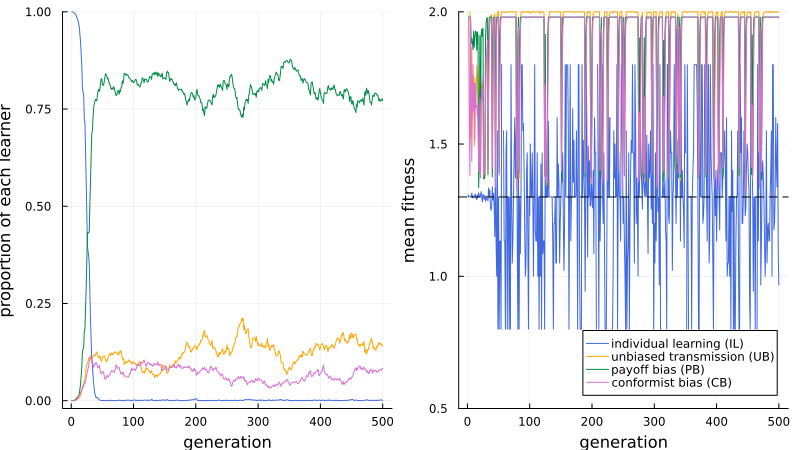

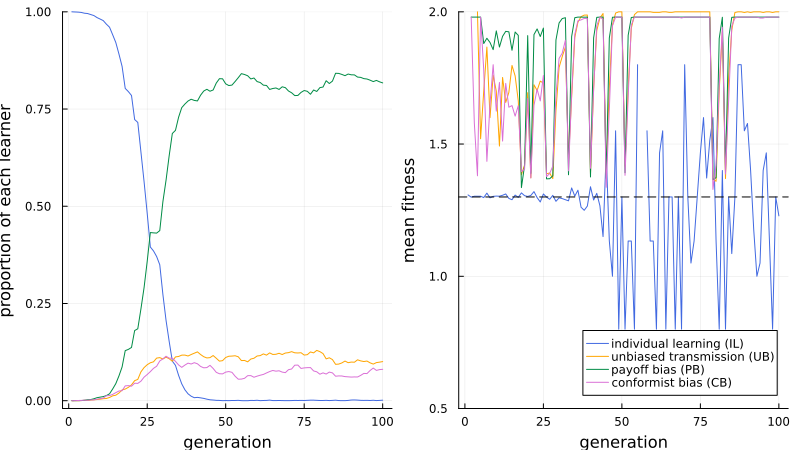

In [3]:
df = SLStemporal()
plot_model19(df)
plot_model19(df[1:100, :])

In [80]:
p_i_list = v_list = 0.5:0.1:1.0
cutoff = 0.5
N = 1_000
time_steps = 1_000

columns = [:ILfreq, :UBfreq, :PBfreq, :CBfreq]
parameters = [(p_i, v) for v in v_list for p_i in p_i_list]
strategy_matrix = fill(0, length(v_list), length(p_i_list))

for (p_i_index, p_i) in enumerate(p_i_list)
    for (v_index, v) in enumerate(v_list)
        output_df = SLStemporal(N = N, time_steps = time_steps, p_i = p_i, v = v)
        strategy = findfirst(>(cutoff), output_df[time_steps, columns])
        strategy = findfirst(==(strategy), columns)
        strategy_matrix[v_index, p_i_index] = isnothing(strategy) ? 0 : strategy
    end
end

┌ Warning: scale none is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1583
┌ Warning: scale none is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1583
┌ Warning: scale none is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1583
┌ Warning: scale none is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1583


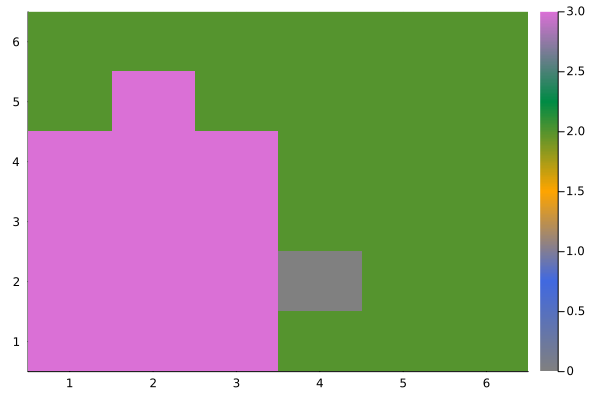

In [81]:
using Plots
heatmap(
    strategy_matrix,
    color = [:grey, :royalblue, :orange, :springgreen4, :orchid],
    breaks = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5],
    scale = :none,
)

## Model 19b: Spatially varying environments

## Summary